<center><h1>Breast Cancer Detection using Machine Learning</h1></center>

In this notebook we will detect breast cancer using the `Wisconsin breast cancer data`. we will make data cleaning, preprocessing, and a list of observations which enabled us to use the `Random Forest Classifier` as the best classifier which gives us the best accuracy.

Install packages, libraries, and modules which we will help us to process on our data.  

In [287]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr, pearsonr
from sklearn.feature_selection import SelectKBest, chi2, SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

<h2> Data Importing and Exploration </h2>

In [289]:
# Read data from csv file.
dataframe = pd.read_csv("breastcancerdata.csv")
# Explore our data.
dataframe.head()
dataframe.describe()
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

<h2> Data Cleaning </h2>

In [290]:
# Cleaning our data.
data_modified = dataframe.drop(labels=["Unnamed: 32", "id"], axis=1)
data_modified['diagnosis'] = data_modified['diagnosis'].map({'M': 1, 'B': 0})

In [291]:
# A function to scatter plot our features with the outcome.  
def plotFeatures(df): 
    fig, ax = plt.subplots(10, 3, figsize=(10,20))
    z=1
    for i in range(10):
        for j in range(3):
            ax[i, j].scatter(df.iloc[:,z], df.iloc[:,0])
            z = z + 1
    plt.tight_layout()
    plt.show()

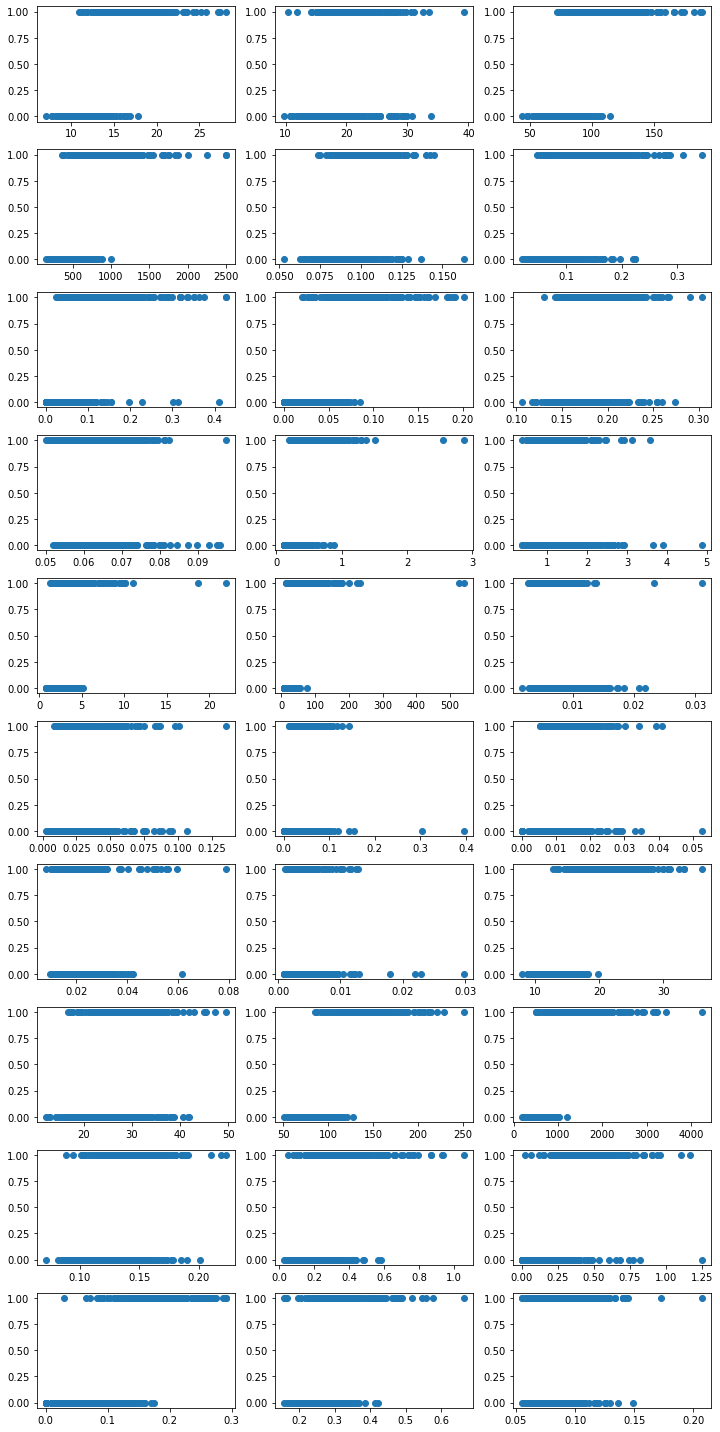

In [261]:
# Plotting our data and check if there is outliers.
plotFeatures(data_modified)

<i><h4>Observations</h4></i>
- As visulaized in the plots there are some outliers according to certain features, which lowers the accuracy and need to be removed.<br>
- Random Forest Classifier is immune to outliers as it is calculated as the average of many decesion trees. 

In [292]:
# Remove outliers
z_scores = stats.zscore(data_modified)
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
data_modified = data_modified[filtered_entries]    

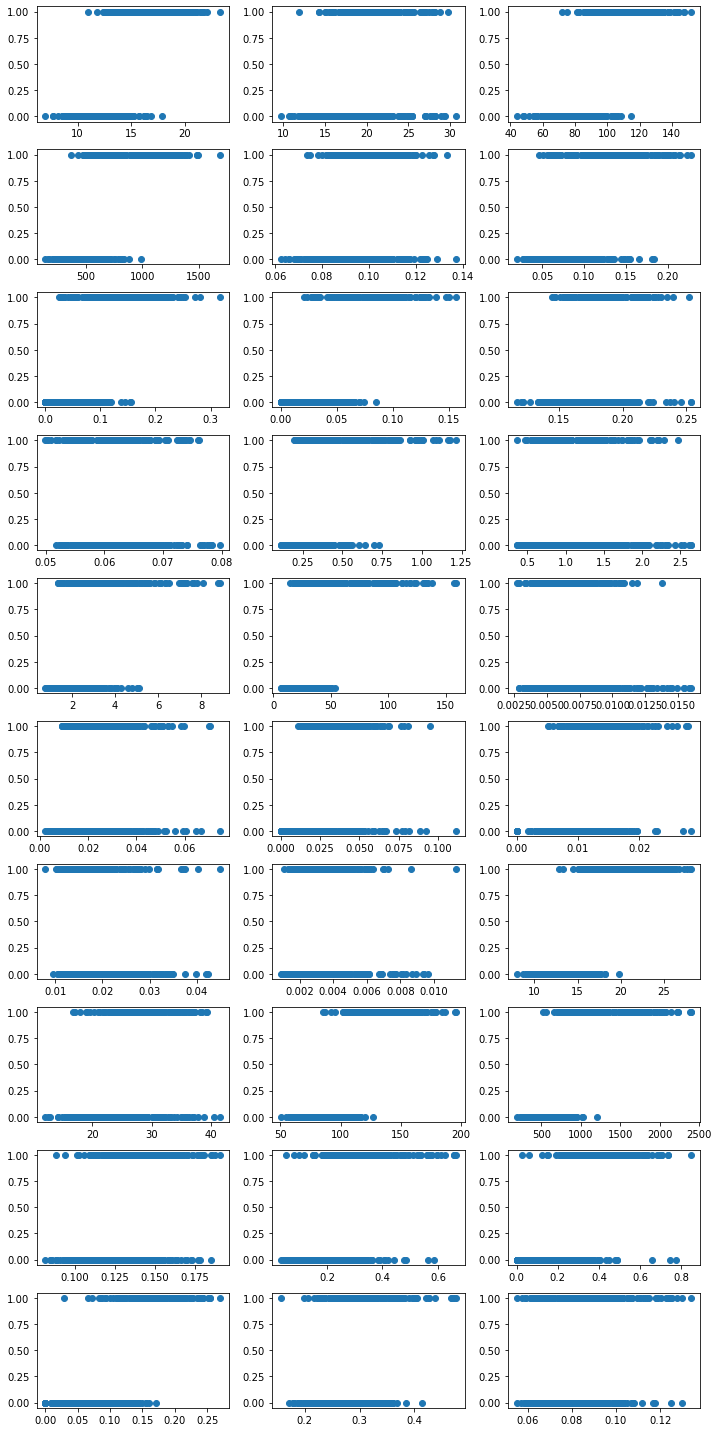

In [293]:
# Plotting our data and check if there the outliers are removed.
plotFeatures(data_modified)

<i><h4>Observations</h4></i>
- All outliers are now removed using the z-distribution.

<h2> Feature Selection </h2>

In [294]:
# split our data into features and outcome.
x = data_modified.drop("diagnosis", axis=1) # All Features
y = data_modified["diagnosis"] # Outcome

<center><h3> Manual Feature Selection using correlation</h3></center>

In [298]:
# A function to select the best features by checking their correlation. 
def manualFeatureSelection(features, outcome, r=0.76, pro=0.01, corrType='p'): 
    # p for pearson's correlation & s for spearman's correlation.  
    # First filter
    # Check correlation between all features and the outcome.
    x1 = []
    for i in features:
        if corrType == 's':
            rho, p = spearmanr(features[str(i)], outcome)
        else:
            rho, p = pearsonr(features[str(i)], outcome)

        if (abs(rho) > r) and (p < pro):
            x1.append(i)
    x2 = features[x1]
    # -----------------------------------------------------------------------------
    # Second filter
    # Check correlation between all features and each other to eliminate redundant features.

    corrColumns = set()  # Set of all the names of correlated columns

    if corrType == 's':
        corr_matrix = x2.corr(method='spearman')
    else:
        corr_matrix = x2.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > r:  # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                corrColumns.add(colname)
    return list(corrColumns)
manualFeatureSelection(x,y)

['concave points_worst', 'perimeter_worst', 'area_worst', 'radius_worst']

In [299]:
# Best manual features selected after many experiments were:
# ['perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst']
x_featuresManual = ['perimeter_worst', 'area_worst', 'radius_worst', 'concave points_worst']

<center><h3> Automatic Feature Selection using SelectKBest module</h3></center>

In [300]:
# Automatic feature selection using SelectKBest
selectAuto = sklearn.feature_selection.SelectKBest(score_func=chi2, k=4)
selectAuto.fit_transform(x, y)

x_featuresAuto = list(x.columns[selectAuto.get_support()])
x_featuresAuto

['area_mean', 'area_se', 'perimeter_worst', 'area_worst']

<h2> Data Splitting </h2>

In [301]:
# Split data into (70%) train data and (30%) test data
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

<h2> Training Different Models </h2>

<center><h3> Decesion Tree Classifier with selecting all the features</h3></center>

In [312]:
#Train the tree model with all features and check the accuracy
treeModel = DecisionTreeClassifier()
treeModel.fit(x_train, y_train)

print("Accuracy score :" +str(accuracy_score(y_test, treeModel.predict(x_test))))
score = cross_val_score(treeModel, x, y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.912751677852349
Cross Validation Scores are [0.87878788 0.91919192 0.92929293 0.92929293 0.91919192]
Average Cross Validation score :0.9151515151515153


<center><h3> Decesion Tree Classifier with selecting all the automatic selected features</h3></center>

In [313]:
#Train the tree model with automatic selected features and check the accuracy
treeModel = DecisionTreeClassifier()
treeModel.fit(x_train[x_featuresAuto], y_train)

print("Accuracy score :" +str(accuracy_score(y_test, treeModel.predict(x_test[x_featuresAuto]))))
score = cross_val_score(treeModel, x[x_featuresAuto], y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.8993288590604027
Cross Validation Scores are [0.88888889 0.90909091 0.93939394 0.93939394 0.8989899 ]
Average Cross Validation score :0.9151515151515153


<center><h3> Decesion Tree Classifier with selecting all the manual selected features</h3></center>

In [306]:
#Train the tree model with manual selected features and check the accuracy
treeModel = DecisionTreeClassifier()
treeModel.fit(x_train[x_featuresManual], y_train)

print("Accuracy score :" +str(accuracy_score(y_test, treeModel.predict(x_test[x_featuresManual]))))
score = cross_val_score(treeModel, x[x_featuresManual], y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.9261744966442953
Cross Validation Scores are [0.84848485 0.87878788 0.95959596 0.91919192 0.85858586]
Average Cross Validation score :0.8929292929292929


<i><h4>Observations</h4></i>
- The highest accuracy & lowest cross validation from the above three examples was the using of  Decesion Tree Classifier with the Manual Selected Features.<br>
- This is still a good indication the our manual selected features are selected on efficient bases.

<center>
    <h3> Tuning the hyperparameters which we will use while using the Random Forest Classifier </h3><br>
    <h4> This is made to prevent model overfitting, increase accuracy, and cross validation score. </h4>   
</center>

In [175]:
#Before Excueting the random forest model we first need to make hyperparamter tuning
from xgboost import XGBRegressor
xgb_model = XGBRegressor(random_state = 2022)

search_space = {
    "n_estimators": [100,200,500],
    "max_depth": [3,7,10],
    "min_samples_split": [25, 50, 100],
    "max_features": [2,4,8]
}

GS = GridSearchCV(estimator = xgb_model,
                 param_grid = search_space,
                 scoring = ["r2", "neg_root_mean_squared_error"],
                 refit = "r2",
                 cv = 5,
                 verbose = 4)

GS.fit(x_train, y_train)

print(GS.best_params_)

Fitting 5 folds for each of 81 candidates, totalling 405 fits
[11:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[CV 1/5] END max_depth=3, max_features=2, min_samples_split=25, n_estimators=100; neg_root_mean_squared_error: (test=-0.260) r2: (test=0.714) total time=   0.0s
[11:59:00] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.6.0/src/learner.cc:627: 
Parameters: { "max_features", "min_samples_split" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter 

<center><h3> Random Forest Classifier with selecting all the features</h3></center>

In [315]:
#As my hyperparameter was {'max_depth': 3, 'max_features': 2, 'min_samples_split': 25, 'n_estimators': 500}
#First lets train our model with all features

forestModel = RandomForestClassifier(max_depth = 3, 
                                     max_features = 2, 
                                     min_samples_split = 25, 
                                     n_estimators = 500)
forestModel.fit(x_train, y_train)

print("Accuracy score :" +str(accuracy_score(y_test, forestModel.predict(x_test))))
score = cross_val_score(forestModel, x, y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.959731543624161
Cross Validation Scores are [0.85858586 0.91919192 0.96969697 0.94949495 0.96969697]
Average Cross Validation score :0.9333333333333332


<i><h4>Observations</h4></i>
- The accuracy & cross validation here are high.<br>
- That is because the Random Forest Classifier is great with high dimensionality.<br>
- As it performs Feature Selection while training the model (A built-in feature). <br>
- To get the selected features, we will achieve that using the next method.

In [320]:
# Create a selector object that will use the random forest classifier to identify
# features that have an importance of more than 0.07
sfm = SelectFromModel(forestModel, threshold=0.08)

# Train the selector
sfm.fit(x_train, y_train)

# Print the names of the most important features
for feature_list_index in sfm.get_support(indices=True):
    print(x.columns[feature_list_index])

perimeter_worst
area_worst
concave points_worst


In [321]:
# Train the Random Forest Classifier model with built in selected features from the random forest algorithm.

forestBuiltFeatures = ["concave points_worst", "area_worst", "perimeter_worst"]
forestModel = RandomForestClassifier(max_depth = 3, 
                                     max_features = 2, 
                                     min_samples_split = 25, 
                                     n_estimators = 500)
forestModel.fit(x_train[forestBuiltFeatures], y_train)

print("Accuracy score :" +str(accuracy_score(y_test, forestModel.predict(x_test[forestBuiltFeatures]))))
score = cross_val_score(forestModel, x, y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.9463087248322147
Cross Validation Scores are [0.84848485 0.91919192 0.96969697 0.94949495 0.95959596]
Average Cross Validation score :0.9292929292929293


<i><h4>Observations</h4></i>
- The accuracy here is a little lower than the Random Forest Model with all features. we could increase the accuracy / features by altering the threeshold value.<br>
- The cross Validation Scores are likely the same.<br>

<center><h3> Random Forest Classifier with selecting all the automatic selected features</h3></center>

In [322]:
#Second lets train our model with automatic selected features

forestModel = RandomForestClassifier(max_depth = 3, 
                                     max_features = 2, 
                                     min_samples_split = 25, 
                                     n_estimators = 500)
forestModel.fit(x_train[x_featuresAuto], y_train)

print("Accuracy score :" +str(accuracy_score(y_test, forestModel.predict(x_test[x_featuresAuto]))))
score = cross_val_score(forestModel, x, y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.9328859060402684
Cross Validation Scores are [0.85858586 0.92929293 0.96969697 0.94949495 0.95959596]
Average Cross Validation score :0.9333333333333333


<center><h3> Random Forest Classifier with selecting all the manual selected features</h3></center>

In [323]:
#Third lets train our model with manual selected features

forestModel = RandomForestClassifier(max_depth = 3, 
                                     max_features = 2, 
                                     min_samples_split = 25, 
                                     n_estimators = 500)
forestModel.fit(x_train[x_featuresManual], y_train)

print("Accuracy score :" +str(accuracy_score(y_test, forestModel.predict(x_test[x_featuresManual]))))
score = cross_val_score(forestModel, x, y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.9530201342281879
Cross Validation Scores are [0.8989899  0.91919192 0.96969697 0.94949495 0.95959596]
Average Cross Validation score :0.9393939393939394


<i><h4>Observations</h4></i>
- The best model which was used according to accuracy & cross validation scores is the Random Forest Classifier with its tuned hyperparameters using GridSearchCV and selecting the manual selected features.<br>
- So, this will be model that we will use with our breast cancer dataset.<br>

In [335]:
#As the best model which was used is the random forest model with applying GridSearchCV to tune its hyperparameters and selecting manual selected features.
breastCancerModel = RandomForestClassifier(max_depth = 3, 
                                     max_features = 2, 
                                     min_samples_split = 25, 
                                     n_estimators = 500)
breastCancerModel.fit(x_train[x_featuresManual], y_train)

print("Accuracy score :" +str(accuracy_score(y_test, breastCancerModel.predict(x_test[x_featuresManual]))))
score = cross_val_score(forestModel, x, y, cv = KFold(n_splits=5))
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Accuracy score :0.9463087248322147
Cross Validation Scores are [0.85858586 0.93939394 0.96969697 0.94949495 0.95959596]
Average Cross Validation score :0.9353535353535353


<center><h3> Final Model </h3></center>
- Classifier: Random Forest Classifier<br>
- Average accuracy: 94.6% <br>
- Average Cross Validation score: 93.7%

In [333]:
# Make a pickle file of our model, to deploy on our flask application.
pickle.dump(breastCancerModel, open("model.pkl", "wb"))

<center><h3> Team 26 </h3></center><br>

| Names        | Section     | Bench Number  |
| :---         |    :----:   |          ---: |
| Mahmoud Yaser| 2           | 29            |
| Omar Anwar   | 2           | 2             |
| Maye Khaled  | 2           | 40            |
| Mayar Ehab   | 2           | 41            |